This is a exercise following [Vincent Tatan's blog at Medium](https://towardsdatascience.com/value-investing-dashboard-with-python-beautiful-soup-and-dash-python-43002f6a97ca).

The goal of this application is to help you retrieve and display the right financial insights quickly about a certain company ticker.

Tool list:
- Beautiful Soup as the Web Scraping Tool
- Pandas data-reader API to get the financial stocks price
- Flask/Dash for Web Application Framework (not used in jupyter notebook mode)
- ipywidgets for interactive widgets in jupyter notebook , follow [Semi Koen's ](https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916) and [Will Koehrsen's](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6) blogs at Medium


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.offline as plyo
import numpy as np
import numpy_financial as npf
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as dash_html
import dash.dependencies as dsah_depend
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display
import dashboard 
from dashboard import *
import stock_info_service 
from stock_info_service import *
from investment_rule import *
import importlib
#importlib.reload(stock_info_service)
# from stock_info_service import *
%load_ext autoreload
%autoreload 2
#%matplotlib inline
cf.offline.go_offline()


Install follow packages to start using Dash :
- The core dash backend.
- Dash front-end
- Dash HTML components
- Dash core components
- Plotly



- !pip install dash
- !pip install dash-renderer
- !pip install dash-html-components
- !pip install dash-core-components
- !pip install plotly --upgrade

In [2]:
### Get stock price record from yahoo
stockprice_df=get_stock_price('GOOG',dt(2020,1,1),end_date=dt.now())

In [3]:
stockprice_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 173 entries, 2019-12-31 to 2020-09-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       173 non-null    float64
 1   Low        173 non-null    float64
 2   Open       173 non-null    float64
 3   Close      173 non-null    float64
 4   Volume     173 non-null    int64  
 5   Adj Close  173 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 9.5 KB


In [4]:
importlib.reload(stock_info_service)
from stock_info_service import *

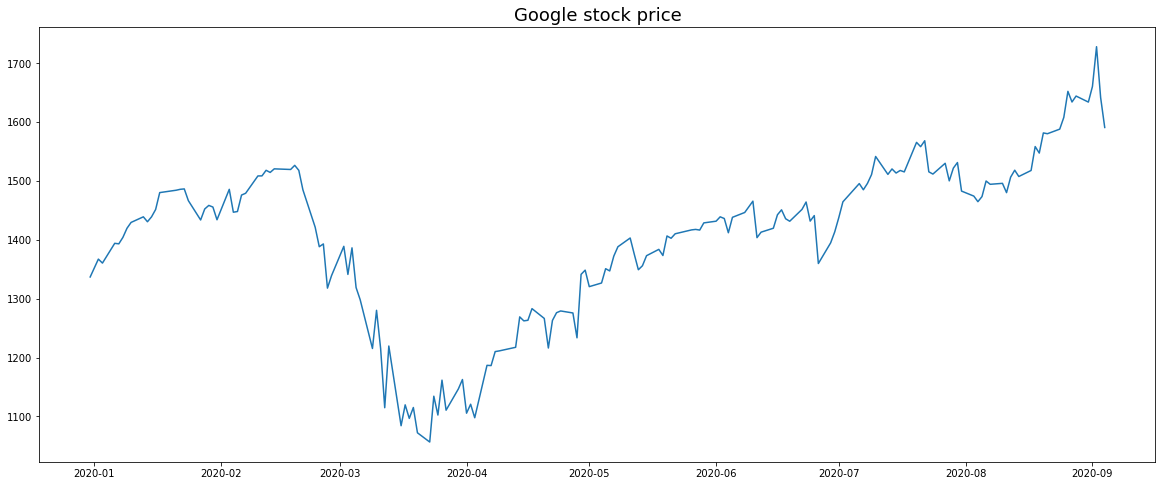

In [5]:
plot_stock_chart('GOOG','Goolge Stock Price History',stockprice_df)

### Parsing fincial information from MarketWatch web site
### For example, get Google's financial information from this url : https://www.marketwatch.com/investing/stock/GOOG/financials

In [6]:
def getelementinlist(list,element):
    try:
        return list[element]
    except:
        return '-'

In [7]:
### try to get APPLE's financial information
financial_url = 'https://www.marketwatch.com/investing/stock/GOOG/financials'
balancesheet_url = 'https://www.marketwatch.com/investing/stock/GOOG/financials/balance-sheet'

text_soup_financials = BeautifulSoup(requests.get(financial_url).text,"lxml")
text_soup_balancesheet = BeautifulSoup(requests.get(balancesheet_url).text,"lxml")

# Income Statement
titlesfinancials = text_soup_financials.findAll('td',{'class':'rowTitle'})

epslist = []
netincomelist = []
longtermdebtlist = []
interestexpenselist = []
ebitdalist = []

for title in titlesfinancials:
    if 'EPS (Basic)' in title.text:
        epslist.append ([td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text])
    if 'Net Income' in title.text:
        netincomelist.append ([td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text])
    if 'Interest Expense' in title.text:
        interestexpenselist.append ([td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text])
    if 'EBITDA' in title.text:
        ebitdalist.append ([td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text])


# Balance sheet
titlesbalancesheet = text_soup_balancesheet.findAll('td', {'class': 'rowTitle'})
equitylist=[]
for title in titlesbalancesheet:
    if 'Total Shareholders\' Equity' in title.text:
        equitylist.append( [td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text])
    if 'Long-Term Debt' in title.text:
        longtermdebtlist.append( [td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text])

eps = getelementinlist(epslist,0)
epsgrowth = getelementinlist(epslist,1)
netincome = getelementinlist(netincomelist,0)
shareholderequity = getelementinlist(equitylist,0)
roa = getelementinlist(equitylist,1)

longtermdebt = getelementinlist(longtermdebtlist,0)
interestexpense =  getelementinlist(interestexpenselist,0)
ebitda = getelementinlist(ebitdalist,0)
# Don't forget to add in roe, interest coverage ratio

## Make it into Dataframes

df= pd.DataFrame({'eps': eps,'epsgrowth': epsgrowth,'netincome': netincome,'shareholderequity':shareholderequity,'roa': roa,'longtermdebt': longtermdebt,'interestexpense':interestexpense,'ebitda': ebitda},index=range(dt.today().year-5,dt.today().year))
df.head()
            

,eps,epsgrowth,netincome,shareholderequity,roa,longtermdebt,interestexpense,ebitda
2015,23.12,-,15.83B,120.33B,81.60%,2B,104M,23.02B
2016,28.32,22.51%,19.48B,139.04B,83.01%,3.94B,124M,29.32B
2017,18.27,-35.47%,12.66B,152.5B,77.30%,3.97B,109M,35.97B
2018,44.22,141.96%,30.74B,177.63B,76.30%,4.01B,114M,40.57B
2019,49.59,12.15%,34.34B,201.44B,73.01%,14.77B,100M,47.25B


### Warning Signs List based on value investing logic ###

Given list of the companies, find out the feasibility to invest

1. Been in market minimal 10 years
1. Have the track records (EPS per year)
1. Have efficiency (ROE > 15%) — Net income / shareholder equity
1. Determine manipulation (ROA > 7%) — Net income / Total Asset
1. Have small long term debt (Long term debt <5* total income)
1. Low Debt to Equity
1. Ability to pay interest: (Interest Coverage Ratio >3) — EBIT / Interest expenses

In [8]:
# Formatting df value to numerical
def format(list):
    newlist=[]
    posornegnumber = 1
    for text in list:
        if text.endswith(')'):
            text = text[1:-1] # remove the parentheses
            posornegnumber = -1
            
        if text.endswith('%'):
#             Then please make it into comma float
            endtext = float(text[:-1].replace(",",""))/100.0 * posornegnumber 
        elif text.endswith('B'):
#             Then please times 1000000000
#             Change it into integer
            endtext = int(float(text[:-1].replace(",",""))*1000000000)* posornegnumber 
        elif text.endswith('M'):
#             Then please times 1000000
#             Change it into integer
            endtext = int(float(text[:-1].replace(",",""))*1000000)* posornegnumber 
        elif ',' in text:
#             Then please remove the ,
#             Then change it into int
            endtext = int(float(text.replace(",","")))* posornegnumber 

        elif text.endswith('-'):
#             Insert 0
            endtext = 0
        else:
#             change to float
            endtext = float(text)* posornegnumber 
        newlist.append(endtext)
    return newlist   

In [9]:
### get formatted financial information
dfformatted = df.apply(format)
# Adding roe, interest coverage ratio
dfformatted['roe'] = dfformatted.netincome/dfformatted.shareholderequity
dfformatted['interestcoverageratio'] = dfformatted.ebitda/dfformatted.interestexpense

In [10]:
eligibilitycheck(dfformatted)

['there is negative growth -0.3547']

### Decision rules for stock transaction

Decision making from each company in terms of return rate given the value investing methodology :

1. Find EPS Annual Compounded Growth Rate
2. Estimate EPS 10 years from now
3. Estimate stock price 10 years from now (Stock Price EPS * Average PE)
4. Determine target by price today based on returns(discount rate 15%/20%)
   - Discount rate indicated predicted inflation over the period of 5 years. 
5. Add margin of safety (Safety net 15%)
   - Margin calculation rate is the toleration for error. You add on additional safety net in the case of calculation error. The more the margin calculation rate, the more risk averse you are or vice versa.
6. Buy if market price is lower than the marginal price
7. Sell if market price is higher than the marginal price

In [11]:
generate_price_df('GOOG',dfformatted,stockprice_df,0.03,0.02)

1st year EPS 23.120000 
5th year EPS 49.590000
Annual Growth Rate 0.164880
PE ration 26.961485


,annualgrowthrate,lasteps,futureeps,peratio,FV,PV,marginprice,lastshareprice,decision
ticker,,,,,,,,,
GOOG,0.16,49.59,228.14,26.96,"6,151.07","4,576.97","4,485.43","1,591.04",BUY


In [12]:
discountSlider = widgets.FloatSlider(
    min = 0.000,
    max = 1.000,
    step = 0.001,
    description='Discount:',
    value = 0
)

discountText = widgets.FloatText()
display(discountSlider,discountText)

widgets.jslink((discountSlider,'value'), (discountText,'value'))

FloatSlider(value=0.0, description='Discount:', max=1.0, step=0.001)

FloatText(value=0.0)

Link(source=(FloatSlider(value=0.0, description='Discount:', max=1.0, step=0.001), 'value'), target=(FloatText…

In [13]:
form_item_layout = widgets.Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

dropdown_stock = widgets.Dropdown(
    options = get_stocks_ipywidgets_options(),
    description='Stock : ',
    layout = widgets.Layout(
        width='auto'
    )
)

op2 = widgets.Output()
#stock_chart = widgets.Output(layout={'border': '0px solid black'})
controls_dict = {'ticker':dropdown_stock}
stock_chart = widgets.interactive_output(plot_stock_k_chart,controls_dict)
box = widgets.VBox([dropdown_stock,stock_chart])
#display(dropdown_stock,op2,stock_chart)

display(dropdown_stock,stock_chart)

def dropdown_stock_eventhandler(obj):
    #with output2:
    #    print(obj['new'])
    try:
        qf = plot_stock_k_chart(obj['new'])
            #fig=qf.iplot(asFigure=True,    dimensions=(800,600))
        
        fig = qf.iplot(asFigure=True, dimensions=(800,600))
        fig2=go.FigureWidget(plyo.iplot(fig))
        display(fig2)
            #with stock_chart.batch_update():
            #    stock_chart.data[0] = qf
                #stock_chart.data[0].marker.color = 'green'
            
    except Exception as e:
        if hasattr(e, 'message'):
            print(e.message)
        else:
            print(e)
        
#dropdown_stock.observe(dropdown_stock_eventhandler,names='value')

Dropdown(description='Stock : ', layout=Layout(width='auto'), options=(('', ''), ('1101 台泥 上市 水泥工業 TWSE', '110…

Output()

In [28]:
app = JupyterDash(__name__)
init_dashboard(app)
# Run app and display result inline in the notebook
app.run_server(mode='inline',port=8123)

Dash app running on http://127.0.0.1:8123/


In [20]:
importlib.reload(dashboard)
from dashboard import *